### SETUP

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import librosa
import datetime
import os

2024-05-21 17:19:48.918546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 17:19:48.918648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 17:19:48.920318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 17:19:48.931475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 17:19:49.983478: W tensorflow/compiler/tf2

### Load the Holy-Quran Dataset

In [2]:
abs_path = os.path.abspath('')
data_path = abs_path + "/data"
wavs_path = data_path + "/audio112114/"
metadata_path = data_path + "/transcription_phonem112114.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "phonem"]
metadata_df = metadata_df[["file_name", "phonem"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,phonem
0,114001_10,qul ʔaʕuwðu birabi naa:si
1,114002_01,maliki naa:si
2,112001_27,qul huwa lahu ʔaħadun


In [3]:
split = int(len(metadata_df) * .8)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 124
Size of the validation set: 32


### Preprocess the Data

In [4]:
# The set of characters accepted in the transcription.
characters = [x for x in "tljˤʒkʃθʔabnu: zwʕmqɣfrsxiðħdh"]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

2024-05-21 17:19:51.097557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:19:51.166900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:19:51.167025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:19:51.170240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:19:51.170310: I external/local_xla/xla/stream_executor

The vocabulary is: ['', 't', 'l', 'j', 'ˤ', 'ʒ', 'k', 'ʃ', 'θ', 'ʔ', 'a', 'b', 'n', 'u', ':', ' ', 'z', 'w', 'ʕ', 'm', 'q', 'ɣ', 'f', 'r', 's', 'x', 'i', 'ð', 'ħ', 'd', 'h'] (size =31)


In [5]:
# An integer scalar Tensor. The window length in samples. It is used to
# calculate the STFT of the signal.
fft_length = frame_length = 2048
# An integer scalar Tensor. The number of samples to step.
frame_step = 512
# The number of Mel frequency bins.
num_mel_bins = 128  # You can adjust this according to your needs
# sample_rate = 22050.0
# sample_rate = tf.cast(sample_rate, dtype=tf.float32)

In [6]:
@tf.function
def encode_single_sample_mel(wav_file, label):
    ###########################################
    # Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    # 3. Change type to float
    # audio = tf.cast(audio, tf.float32)
    # sample_rate = tf.cast(sample_rate, tf.float32)    
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    # num_spectrogram_bins = tf.cast(num_spectrogram_bins, dtype=tf.float32)
    # 5. Create mel filter
    lowest_freq = 20.0
    high_freq = tf.cast(sample_rate / 2, dtype=tf.float32)
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lowest_freq, high_freq
    )
    # 6. Apply the filter to the spectrogram
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    # 7. Convert to db
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # 8. normalisation
    means = tf.math.reduce_mean(mel_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrogram, 1, keepdims=True)
    mel_spectrogram = (mel_spectrogram - means) / (stddevs + 1e-10)    
    ###########################################
    # Process the label
    ##########################################
    # 9. Convert label to Lower case
    label = tf.strings.lower(label)
    # 10. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 11. Map the characters in label to numbers
    label = char_to_num(label)
    # 12. Return a dict as our model is expecting two inputs
    return mel_spectrogram, label


In [7]:
for i in range(1):
    print(i)
    print(encode_single_sample_mel(df_train["file_name"].iloc[i], df_train["phonem"].iloc[i]))

0


2024-05-21 17:19:53.800775: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(<tf.Tensor: shape=(260, 128), dtype=float32, numpy=
array([[-1.7618197 , -1.6598445 , -1.7318535 , ...,  0.84887505,
         0.7676522 , -0.49691305],
       [-1.3315446 , -0.99972636, -0.93355095, ...,  0.40812775,
         0.35778853, -0.57497984],
       [-1.6321577 , -1.0580217 , -0.8344771 , ..., -0.41992158,
        -0.41668543, -1.1978414 ],
       ...,
       [-2.3961794 , -2.4746552 , -2.5175552 , ..., -0.31466424,
        -1.9789368 , -1.9931145 ],
       [-2.686193  , -2.412077  , -2.5070777 , ..., -0.8172352 ,
        -1.9442694 , -1.9577374 ],
       [-2.5871432 , -2.4350567 , -2.483014  , ..., -1.8708507 ,
        -1.9571958 , -1.7384331 ]], dtype=float32)>, <tf.Tensor: shape=(25,), dtype=int64, numpy=
array([20, 13,  2, 15,  9, 10, 18, 13, 17, 27, 13, 15, 11, 26, 23, 10, 11,
       26, 15, 12, 10, 10, 14, 24, 26])>)


### Creating Dataset Objects

In [8]:
batch_size = 4
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["phonem"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["phonem"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Sample rate seharusnya: 22050


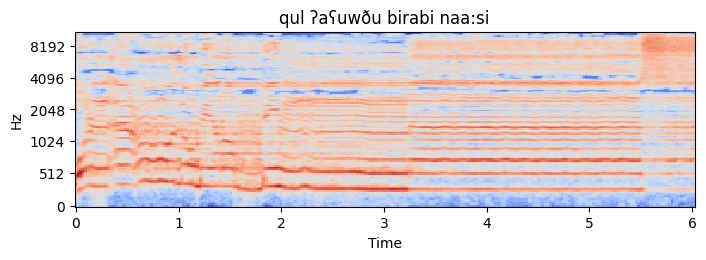

In [9]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    mel_spectrogram = batch[0][0].numpy()
    mel_spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(mel_spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    # ax.imshow(mel_spectrogram, vmax=1)
    ax.set_title(label)
    # ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, sr = tf.audio.decode_wav(file)
    sr = sr.numpy()
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis="time", y_axis="mel")
    print(f"Sample rate seharusnya: {sr}")
    audio = audio.numpy()
    # ax = plt.subplot(2, 1, 2)
    # plt.plot(audio)
    # ax.set_title("Signal Wave")
    # ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=sr))
plt.show()

### Model

In [10]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [11]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Build model based on the provided architecture."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    
    # First 2D Conv layer
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_1"
    )(x)
    x = layers.LayerNormalization(name="ln_1")(x)
    x = layers.Activation("gelu", name="gelu_1")(x)
    x = layers.Dropout(0.1, name="dropout_1")(x)
    
    # Residual block with 2D Conv layers
    residual = x
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_2"
    )(x)
    x = layers.LayerNormalization(name="ln_2")(x)
    x = layers.Activation("gelu", name="gelu_2")(x)
    x = layers.Dropout(0.1, name="dropout_2")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_3"
    )(x)
    x = layers.LayerNormalization(name="ln_3")(x)
    x = layers.Activation("gelu", name="gelu_3")(x)
    x = layers.Dropout(0.1, name="dropout_3")(x)
    
    # Adding the residual connection
    x = layers.Add(name="add")([x, residual])
    
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    # RNN layers with BiGRU
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
        )
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}")(x)
        if i < rnn_layers:
            x = layers.LayerNormalization(name=f"ln_{i + 3}")(x)
            x = layers.Activation("gelu", name=f"gelu_{i + 3}")(x)
            x = layers.Dropout(0.1, name=f"dropout_{i + 3}")(x)
    
    # Classifier layers
    x = layers.Dense(units=rnn_units * 2, name="classifier_fc1")(x)
    x = layers.Activation("gelu", name="classifier_gelu")(x)
    x = layers.Dropout(0.1, name="classifier_dropout")(x)
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="classifier_fc2")(x)
    
    # Model
    model = tf.keras.Model(input_spectrogram, output, name="RNN-CTC")
    
    # Compile the model and return
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=CTCLoss)
    return model

In [12]:
# Get the model
model = build_model(
    input_dim=num_mel_bins,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "RNN-CTC"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input (InputLayer)              [(None, None, 128)]              0          []                               
                                                                                                              
 expand_dim (Reshape)            (None, None, 128, 1)             0          ['input[0][0]']                  
                                                                                                              
 conv_1 (Conv2D)                 (None, None, 128, 32)            320        ['expand_dim[0][0]']             
                                                                                                              
 ln_1 (LayerNormalization)       (None, None, 128, 32)            64         ['conv_1[0][0]']  

### Training and Evaluating

In [13]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [14]:
# Define the number of epochs.
epochs = 100
# Define the log directory for tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_loss", save_best_only=True
)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, 
            tensorboard_callback,
            early_stopping, 
            checkpoint],
)

Epoch 1/100


2024-05-21 17:20:25.699841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/RNN-CTC/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-21 17:20:27.293412: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-21 17:20:28.363293: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 17:20:30.193110: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb9b0a459c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 17:20:30.193193: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-21 17:20:30.198684: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR

 2/31 [>.............................] - ETA: 43s - loss: 693.0468   

2024-05-21 17:20:48.651435: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 691.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 17:20:54.589868: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 691.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


13/31 [===========>..................] - ETA: 1:02 - loss: 206.6290

2024-05-21 17:21:26.630320: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 623.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 17:21:31.811741: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 623.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


14/31 [============>.................] - ETA: 1:17 - loss: 199.6527

2024-05-21 17:21:45.463831: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 686.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 17:21:51.886318: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 686.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


20/31 [==================>...........] - ETA: 52s - loss: 169.8377

2024-05-21 17:22:18.511286: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 30.00MiB (rounded to 31457536)requested by op CudnnRNN
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-21 17:22:18.511422: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-05-21 17:22:18.511567: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 125, Chunks in use: 125. 31.2KiB allocated for chunks. 31.2KiB in use in bin. 4.7KiB client-requested in use in bin.
2024-05-21 17:22:18.511592: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 512B client-requested in use in bin.
2024-05-21 17:22:18.511602: I e

CancelledError: Graph execution error:

Detected at node CTCLoss/Log/_134 defined at (most recent call last):
<stack traces unavailable>
RecvAsync is cancelled.
	 [[{{node CTCLoss/Log/_134}}]] [Op:__inference_train_function_30689]

### Inference

In [19]:
def decode_batch_prediction_without_ctc(pred):
    results = tf.argmax(pred, axis=2)
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [22]:
# load model .h5
new_model = keras.models.load_model("model.h5", custom_objects={"CTCLoss": CTCLoss})
new_model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 128)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 128, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 64, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizat  (None, None, 64, 32)      128       
 ion)                                                            
                                                                 
 conv_1_relu (ReLU)          (None, None, 64, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 32, 32)      236544    
                                                      

In [25]:
# Let's check results on more validation samples
predictions = []
predictions_no_ctc = []
targets = []
for batch in validation_dataset:
    X, y = batch
    print(X.shape)
    batch_predictions = new_model.predict(X)
    batch_predictions_no_ctc = decode_batch_prediction_without_ctc(batch_predictions)
    batch_predictions_ctc = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions_ctc)
    predictions_no_ctc.extend(batch_predictions_no_ctc)
        
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print(f"Prediction without CTC: {predictions_no_ctc[i]}")
    print("-" * 100)

(4, 570, 128)
1/1 [==============================] - 2s 2s/step
(4, 467, 128)
1/1 [==============================] - 1s 964ms/step
(4, 566, 128)
1/1 [==============================] - 2s 2s/step
(4, 319, 128)
1/1 [==============================] - 0s 482ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4677
----------------------------------------------------------------------------------------------------
Target    : ʔilahi naa:si
Prediction: ʔilahi na:si
Prediction without CTC: ʔʔiillaaahhiiii   nnna::ssii
----------------------------------------------------------------------------------------------------
Target    : wamin ʃari ɣaa:siqin ʔiðaa: waqaba
Prediction: wamin ʃari ɣa:siqin ʔa: wa
Prediction without CTC: waamminn  ʃʃaarriii  ɣɣɣaaaaaa::ssiiqqiinn  ʔʔaaaaaa:::  wwwwaaaaaaaaaaaaaaaa
----------------------------------------------------------------------------------------------------
Target    : qul ʔa